# Diffusivity finalised

Diffusivity as a function of a tracer?

In [1]:
using Oceananigans, Oceananigans.Advection, Oceananigans.Fields, Oceananigans.Grids
using Oceananigans.AbstractOperations
using Oceananigans.OutputWriters
using Optim
using BenchmarkTools
using JLD2
using Plots

In [42]:
Ny,Nz = 64, 64

(64, 64)

In [43]:
yLength,zLength = 2, 2

(2, 2)

In [53]:
grid2D = RegularCartesianGrid(topology = (Bounded, Bounded, Bounded),
                              size=(1, 64, 64), 
                              #extent=(2π, 2π, 2π))
                              x=(-π, π), y=(-yLength/2, yLength/2), z=(-zLength, 0))

RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}
                   domain: x ∈ [-3.141592653589793, 3.141592653589793], y ∈ [-1.0, 1.0], z ∈ [-2.0, 0.0]
                 topology: (Bounded, Bounded, Bounded)
  resolution (Nx, Ny, Nz): (1, 64, 64)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (6.283185307179586, 0.03125, 0.03125)

In [54]:
v_bcs = VVelocityBoundaryConditions(grid2D,
           top = BoundaryCondition(Value, 0.0),
        bottom = BoundaryCondition(Value, 0.0),
         north = BoundaryCondition(NormalFlow, 0.0),
         south = BoundaryCondition(NormalFlow, 0.0)
)
w_bcs = WVelocityBoundaryConditions(grid2D,
        north = BoundaryCondition(Value, 0.0),
        south = BoundaryCondition(Value, 0.0),
          top = BoundaryCondition(NormalFlow, 0.0),
       bottom = BoundaryCondition(NormalFlow, 0.0)
)

Oceananigans.FieldBoundaryConditions (NamedTuple{(:x, :y, :z)}), with boundary conditions
├── x: CoordinateBoundaryConditions{BoundaryCondition{Flux,Nothing},BoundaryCondition{Flux,Nothing}}
├── y: CoordinateBoundaryConditions{BoundaryCondition{Value,Float64},BoundaryCondition{Value,Float64}}
└── z: CoordinateBoundaryConditions{BoundaryCondition{NormalFlow,Float64},BoundaryCondition{NormalFlow,Float64}}

In [55]:
model2D = IncompressibleModel(timestepper = :RungeKutta3,
                      advection = WENO5(),
                           grid = grid2D,
                       buoyancy = BuoyancyTracer(),
                        tracers = :b,
            boundary_conditions = (v=v_bcs, w=w_bcs),
                        closure = IsotropicDiffusivity(ν = 1e-2, 
                                                       κ = 0)
)

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

### Setting buoyancy

In [56]:
height = 0.6; # 1.0
width = 0.30; # 0.5
buoyancy_amp = -1e-1;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = buoyancy_amp*(width>sqrt((y-0)^2 + (z+height)^2))

set!(model2D, b=initial_buoyancy)

In [57]:
u, v, w = model2D.velocities;
b = model2D.tracers.b

Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (7, 70, 70)
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
└── boundary conditions: x=(west=ZeroFlux, east=ZeroFlux), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=ZeroFlux, top=ZeroFlux)

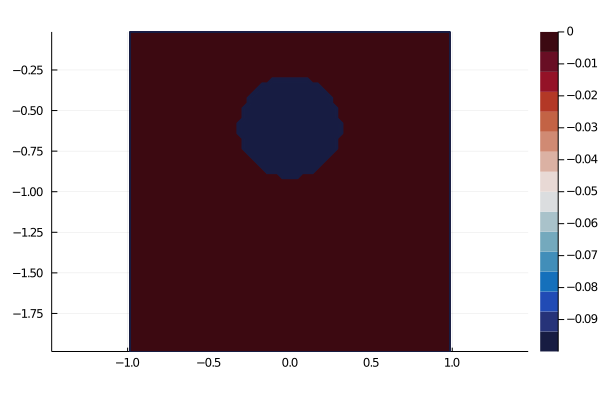

In [58]:
s = sqrt(v^2 + w^2)

s_field = ComputedField(s)

ω = ∂y(w) - ∂z(v)

ω_field = ComputedField(ω)

xb, yb, zb = nodes(b)
contourf(yb,zb,b[1,1:Ny,1:Nz]',color=:balance, aspect_ratio=:equal) # balance/inferno

In [59]:
progress(sim) = @info "Iteration: $(sim.model.clock.iteration), time: $(round(Int, sim.model.clock.time))"

simulation = Simulation(model2D, Δt=0.002, # 0.02
    stop_time=40.0, iteration_interval=1000, progress=progress);

scheduler = TimeInterval(0.5)

using Oceananigans.Diagnostics

nc = NaNChecker(model2D, schedule=scheduler, fields=model2D.velocities)

#simulation.diagnostics[:nc] = nc

using Oceananigans.OutputWriters

simulation.output_writers[:fields] = 
        JLD2OutputWriter(model2D, 
                         (b=b,v=v,w=w,ω=ω_field, s=s_field),
                          schedule = scheduler,
                          prefix = "gravity_current",
                          force = true);

In [60]:
run!(simulation)

┌ Info: Iteration: 1000, time: 2
└ @ Main In[59]:1
┌ Info: Iteration: 2000, time: 4
└ @ Main In[59]:1
┌ Info: Iteration: 3000, time: 6
└ @ Main In[59]:1
┌ Info: Iteration: 4000, time: 8
└ @ Main In[59]:1
┌ Info: Iteration: 5000, time: 10
└ @ Main In[59]:1
┌ Info: Iteration: 6000, time: 12
└ @ Main In[59]:1
┌ Info: Iteration: 7000, time: 14
└ @ Main In[59]:1
┌ Info: Iteration: 8000, time: 16
└ @ Main In[59]:1
┌ Info: Iteration: 9000, time: 18
└ @ Main In[59]:1
┌ Info: Iteration: 10000, time: 20
└ @ Main In[59]:1
┌ Info: Iteration: 11000, time: 22
└ @ Main In[59]:1
┌ Info: Iteration: 12000, time: 24
└ @ Main In[59]:1
┌ Info: Iteration: 13000, time: 26
└ @ Main In[59]:1
┌ Info: Iteration: 14000, time: 28
└ @ Main In[59]:1
┌ Info: Iteration: 15000, time: 30
└ @ Main In[59]:1
┌ Info: Iteration: 16000, time: 32
└ @ Main In[59]:1
┌ Info: Iteration: 17000, time: 34
└ @ Main In[59]:1
┌ Info: Iteration: 18000, time: 36
└ @ Main In[59]:1
┌ Info: Iteration: 19000, time: 38
└ @ Main In[59]:1
┌ Info

┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
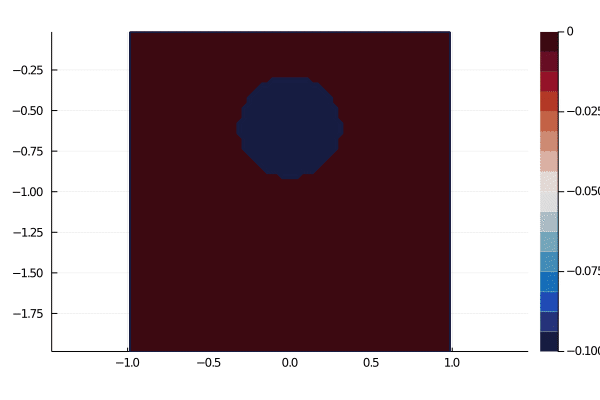

In [61]:
file = jldopen(simulation.output_writers[:fields].filepath)
iterations = parse.(Int, keys(file["timeseries/t"]));
# Plot buoyancy

@gif for iter in iterations
    # retrieve solution from JLD2 file

    #t = file["timeseries/t/$iter"]
    b_snapshot = file["timeseries/b/$iter"][1, :, :]
    #b_snapshot = file["timeseries/v/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/w/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/ω/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/s/$iter"][1, 1:64, 1:64]

    contourf(yb, zb, b_snapshot',color=:balance, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 
    end

In [68]:
model2D.pressure_solver.wavenumbers

(kx² = [0.0], ky² = [0.0 2.46690569180694 … 4086.1383202246593 4093.533094308193], kz² = [0.0]

[2.46690569180694]

[9.861679775340777]

...

[4073.8334924078713]

[4086.1383202246593]

[4093.533094308193])

### Test making into bitmap

┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
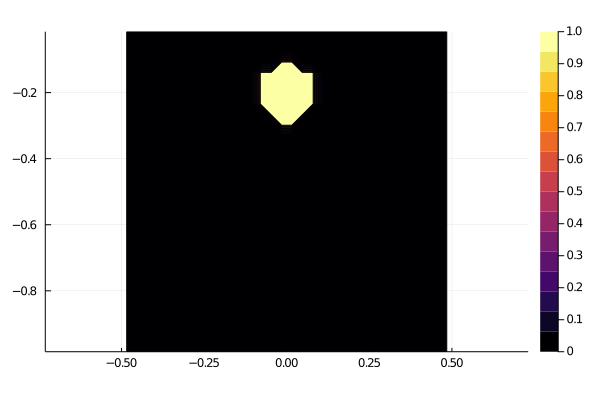

In [738]:
threshold(x) = x < -0.02
@gif for iter in iterations
    # retrieve solution from JLD2 file

    b_snapshot = threshold.(file["timeseries/b/$iter"][1, :, :])
    
    contourf(yb, zb, b_snapshot',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 
end

In [739]:
iterations'[50]

24500

A single image

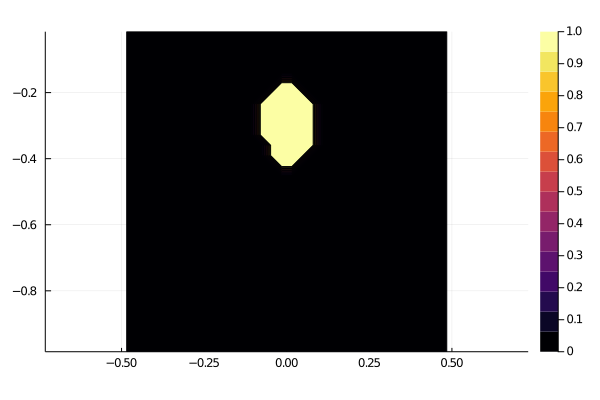

In [740]:
b_snapshot = threshold.(file["timeseries/b/24500"][1, :, :])
contourf(yb, zb, b_snapshot',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [741]:
# Circle function
circ_guess(y,z,r,y₀,z₀) = (r>sqrt((y-y₀)^2 + (z-z₀)^2))

circ_guess (generic function with 1 method)

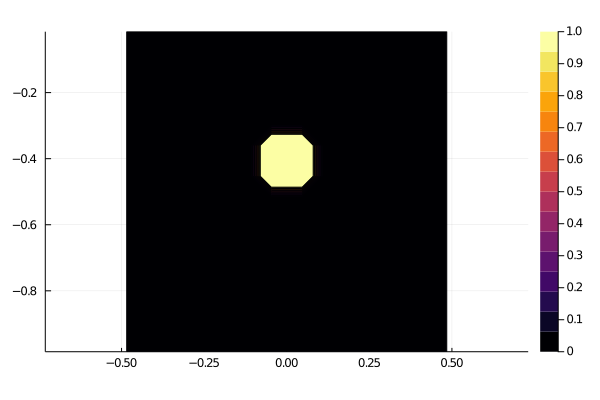

In [745]:
circ_guess1(y, z) = circ_guess(y,z,0.1,0,-0.4)

contourf(yb, zb, circ_guess1.(yb, zb')',color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [746]:
# Misfit
function plot_error(data, yb, zb, r, y₀, z₀)
    
    circ_guess_in(y,z) = circ_guess(y,z,r,y₀,z₀)
    
    circ_guess_data = circ_guess_in.(yb, zb')
end
const guess_cache = circ_guess.(yb,zb',0,0,0)
function circ_error(data, circ_guess_data, yb, zb, r, y₀, z₀)
    
    circ_guess_in(y,z) = circ_guess(y,z,r,y₀,z₀)
    
    for (i, yy) in enumerate(yb), (j, zz) in enumerate(zb)
        circ_guess_data[i,j] = circ_guess_in(yy, zz)
        circ_guess_data[i,j] ⊻= data[i,j]
    end
    #circ_guess_data .= circ_guess_in.(yb, zb')
    
    #circ_guess_data -= data
    
    #circ_guess_data = abs.(circ_guess_data)
    
    
    return reduce(+, circ_guess_data)
end

circ_error (generic function with 2 methods)

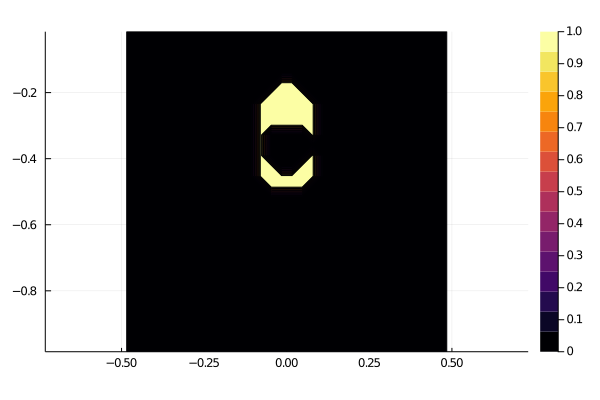

In [753]:
contourf(yb, zb, abs.(plot_error(b_snapshot, yb, zb, 0.1,0,-0.4)' - b_snapshot'),color=:inferno, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 

In [748]:
circ_error(b_snapshot, guess_cache, yb, zb, 0.1,0,-0.4)

43

In [749]:
circ_error(b_snapshot, guess_cache, yb, zb, 0.6,0,-5)

41

In [754]:
struct ParameterGrid2D2
    r_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
    y₀_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
    z₀_range::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}
end

In [755]:
const gridCoarse2 = ParameterGrid2D2(0.1:0.1:1.0, -0.5:0.1:0.5, -1:0.1:0);

In [756]:
const b_test = copy(b_snapshot)
const yb_test = copy(yb)
const zb_test = copy(zb)
function grid_search(pgrid::ParameterGrid2D2)
    i_loc, j_loc, k_loc = 1, 1, 1
    
    val_min = circ_error(b_test, guess_cache, yb_test, zb_test, 
            pgrid.r_range[1], pgrid.y₀_range[1], pgrid.z₀_range[1])
    for (i, r) in enumerate(pgrid.r_range)
        for (j, y) in enumerate(pgrid.y₀_range)
            for (k, z) in enumerate(pgrid.z₀_range)
                err = circ_error(b_test, guess_cache, yb_test, zb_test, r, y, z)
                if err < val_min
                    val_min = err
                    i_loc, j_loc, k_loc = i, j, k
                end
            end
        end
    end
    return (i_loc, j_loc, k_loc), val_min
end

grid_search (generic function with 3 methods)

In [757]:
tmp2 = grid_search(gridCoarse2)
println(tmp2)
println("r = ", gridCoarse2.r_range[tmp2[1][1]])
println("y = ", gridCoarse2.y₀_range[tmp2[1][2]])
println("z = ", gridCoarse2.z₀_range[tmp2[1][3]])

((1, 6, 8), 11)
r = 0.1
y = 0.0
z = -0.3


In [758]:
to_minim(x) = circ_error(b_test, guess_cache, yb_test, zb_test, x[1], x[2], x[3])

to_minim (generic function with 1 method)

In [759]:
to_minim([0.1, 0.0, -0.3])

11

### Using Optim.jl

In [760]:
x0 = [0.1, 0.0, -0.3]
res = optimize(to_minim, x0)
res.minimizer

3-element Array{Float64,1}:
  0.1073255456609125
  0.0007314680868053786
 -0.2959160546492127

In [761]:
to_minim(res.minimizer)

5